In [319]:
# Imports
import numpy as np
import pandas as pd
import re
import seaborn as sns
import scipy
import contractions
import matplotlib.pyplot as plt
%matplotlib inline

import spacy
# Loading the english language small model of spaCy
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [320]:
# Reading CSV File into Pandas DataFrame
df = pd.read_csv('Data/IMDB Dataset.csv',
                 nrows = 1000)
df['review'] = df['review'].str.lower()
df['sentiment'] = df['sentiment'].str.replace('none', '')
df['sentiment'] = df['sentiment'].fillna('')
print('Data Set Size:', df.shape)

Data Set Size: (1000, 2)


In [321]:
# Label Encoding
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
# print(df['sentiment'])

In [322]:
# Text Lemmatization
def lemmatization(text):
    doc = nlp(text)
    temp_list = []
    for token in doc:
        temp_list.append(token)
    return ' '.join(map(str, temp_list))

def tokenize(text):
    return [i.text for i in tokenizer(text)]

# Stop Word Removal
def stopword_removal(text):
    temp_list = []
    for item in tokenize(text):
        if item not in stopwords:
            temp_list.append(item)
    return ' '.join(temp_list)

In [323]:
# Pre-Process Text
def preprocess_text(text):
    # Removing all HTML Tags
    text = re.sub(r'<.*?>', '', text)
    # Removing links
    text = re.sub(r'http\S+', '', text)
    # Remove Text Contractions
    text = contractions.fix(text)
    # Removing special characters and numbers
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    # Lemmatization
    text = lemmatization(text)
    # Stop word Removal
    text = stopword_removal(text)
    # Removing single characters
    text = re.sub(r's+[a-zA-Z]s+', '', text)
    # Replacing multi-spaces by a single space
    text = re.sub(r'\s+', ' ', text)
    return text

In [324]:
x = df['review']
x_corpus = []
for idx, row in x.items():
    sentence = preprocess_text(row)
    x_corpus.append(sentence)
# print(x_corpus[0:1])

y = df['sentiment']

# Fit Tf-Idf Vectorizer to Training text
vectorizer = TfidfVectorizer(ngram_range = (1, 2), 
                             min_df = 2)

# x_train_vector = vectorizer.fit_transform(x_train)
# x_test_vector = vectorizer.transform(x_test)
# print(x_test_vector.shape)

x_corpus = vectorizer.fit_transform(x_corpus)
# print(x_corpus.shape)

# Splitting the dataset into the Training set and Validation set
np.random.seed(32)
x_train, x_test, y_train, y_test = train_test_split(x_corpus, 
                                                    y, 
                                                    random_state = 0, 
                                                    test_size = 0.1, 
                                                    shuffle = True)


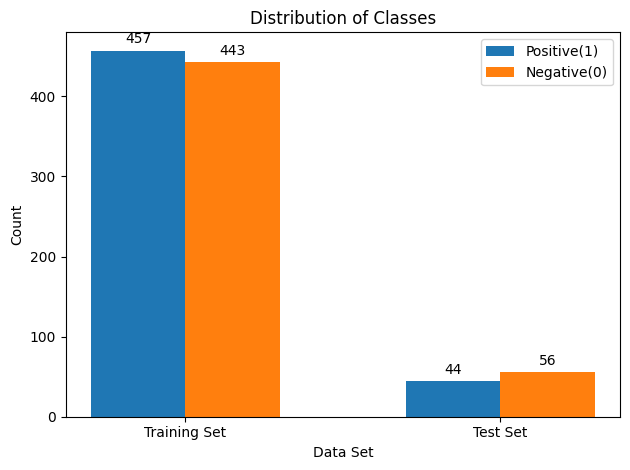

In [325]:
# Class Disribution in the Dataset
def class_distribution(data):
    count_positive = 0
    count_negative = 0
    for idx, row in data.items():
        if row == 1:
            count_positive += 1
        else:
            count_negative +=1
    return count_positive, count_negative

y_train_positive,  y_train_negative = class_distribution(y_train)
y_test_positive,  y_test_negative = class_distribution(y_test)
        
# Plot of Class Disribution in the Dataset    
labels = ['Training Set', 'Test Set']
positive = [y_train_positive, y_test_positive]
negative = [y_train_negative, y_test_negative]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, 
                positive, 
                width, 
                label='Positive(1)')
rects2 = ax.bar(x + width/2, 
                negative, 
                width, 
                label='Negative(0)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_xlabel('Data Set')
ax.set_title('Distribution of Classes')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [327]:
# Applying SVM to Training Text
clf_svm = svm.SVC(kernel = 'linear')
clf_svm.fit(x_train, y_train)
# Evaluate SVM
svm_predicted = clf_svm.predict(x_test)
svm_score = clf_svm.score(x_test, y_test)
print('SVM Score: ', svm_score)
svm_report = classification_report(y_test, svm_predicted)
print(svm_report)

SVM Score:  0.79
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        56
           1       0.73      0.84      0.78        44

    accuracy                           0.79       100
   macro avg       0.79      0.80      0.79       100
weighted avg       0.80      0.79      0.79       100



In [340]:
# Applying Naive Bayes to Training Text
clf_naive = BernoulliNB(alpha = 1 , 
                        binarize = 0.0 , 
                        fit_prior = False , 
                        class_prior = None)
clf_naive.fit(x_train, y_train)  
# Evaluate NB
nb_predicted = clf_naive.predict(x_test)
naive_score = clf_naive.score(x_test, y_test)
print('Naive Bayes Score: ', naive_score)
naive_report = classification_report(y_test, nb_predicted)
print(svm_report)

Naive Bayes Score:  0.8
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        56
           1       0.73      0.84      0.78        44

    accuracy                           0.79       100
   macro avg       0.79      0.80      0.79       100
weighted avg       0.80      0.79      0.79       100



In [344]:
# K-Fold Cross Validation: SVM
k_fold = KFold(n_splits = 10, 
               random_state = 0, 
               shuffle = True)
results = cross_val_score(clf_svm,
                         x_corpus,
                         y,
                         cv = k_fold)
print('Accuracy for each of the 10 Folds -> SVM: ', results)
print('Mean Accuracy for 10 Folds -> SVM: ', results.mean())

Accuracy for each of the 10 Folds -> SVM:  [0.79 0.82 0.92 0.78 0.86 0.84 0.78 0.88 0.76 0.74]
Mean Accuracy for 10 Folds -> SVM:  0.817


In [ ]:
# K-Fold Cross Validation: Naive Bayes
k_fold = KFold(n_splits = 10, 
               random_state = 0, 
               shuffle = True)
results = cross_val_score(clf_svm,
                         x_corpus,
                         y,
                         cv = k_fold)
print('Accuracy for each of the 10 Folds -> SVM: ', results)
print('Mean Accuracy for 10 Folds -> SVM: ', results.mean())